**Ghouls, Goblins, and Ghosts... Boo:** 
Random Forest Classifier has been used in this project to identify between Ghouls, Goblins and Ghosts based on the given feature. 

In [1]:
# Importing the Required Libaries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets

iris = datasets.load_iris()

plt.style.use('seaborn')

In [2]:
# Reading the Train and Test files
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
submission = pd.read_csv("../input/sample_submission.csv")
submission["type"] = "Unknown"

### Checking if there are any Null values or not. If there are any we need to handle them.

In [3]:
print("Train Data Null Values Count \n",train_df.isna().sum())
print("Test Data Null Values Count \n",test_df.isna().sum())

Train Data Null Values Count 
 id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64
Test Data Null Values Count 
 id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
dtype: int64


Since there are no missing values we can continue our work further. If are any missing values I have explained in detail what steps we should take in my [blog](http://https://thedatafreak.wordpress.com/2018/08/16/foreplay-before-doing-data-part-i-handling-missing-data/).

### Taking a look at the distribution
If the features have normal distrubtion we can move forward, else we have to use some transformation for making them normal. 

## Train Data Distribution

C:\Users\user\Anaconda5\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


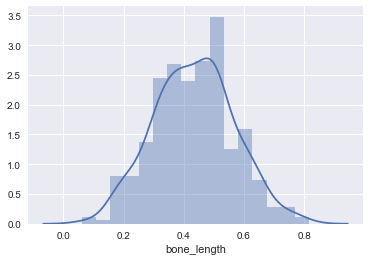

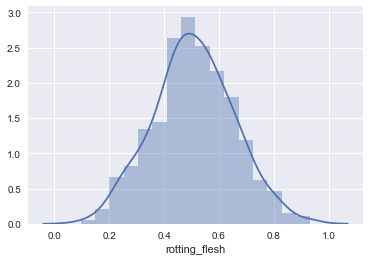

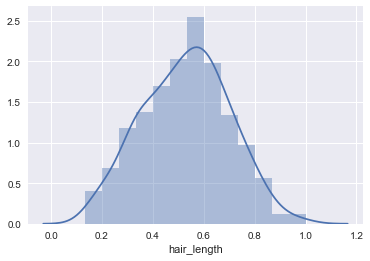

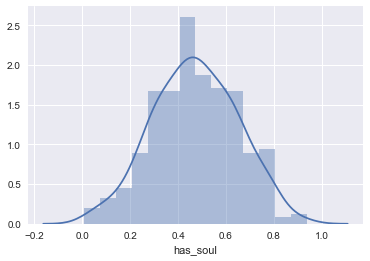

In [4]:
for col in train_df.drop(columns=['id','color','type'],axis=1).columns:
    sns.distplot(train_df[col])
    plt.show()

## Test Data Distrubtion

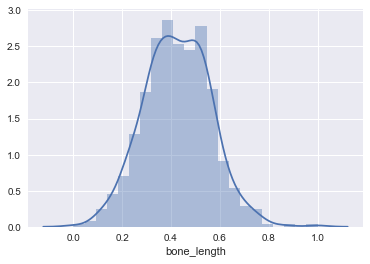

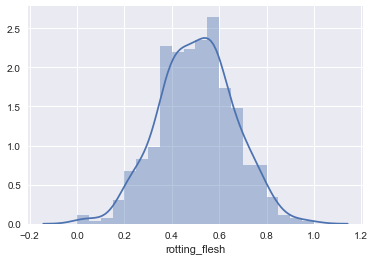

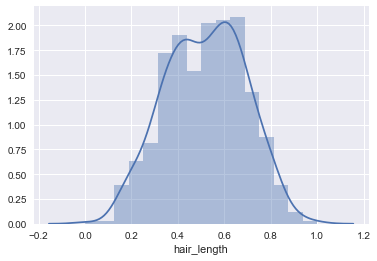

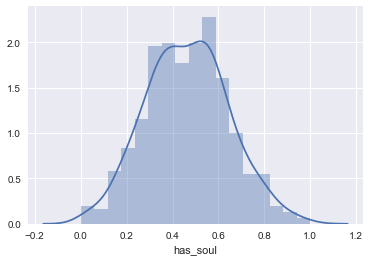

In [5]:
for col in test_df.drop(columns=['id','color'],axis=1).columns:
    sns.distplot(test_df[col])
    plt.show()

In [6]:
train_df.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [7]:
test_df.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


**Since the Normal Distribution Rule only applies to the Numeric data. For the Categorical data we need to take a look at the bar graph**

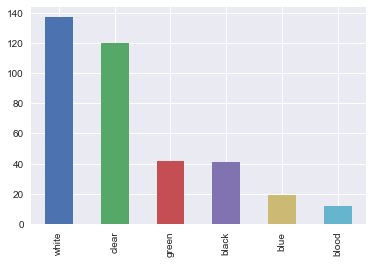

In [8]:
train_df.color.value_counts().plot(kind='bar')

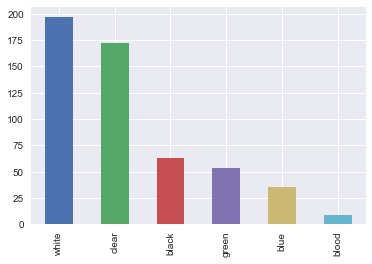

In [9]:
test_df.color.value_counts().plot(kind='bar')

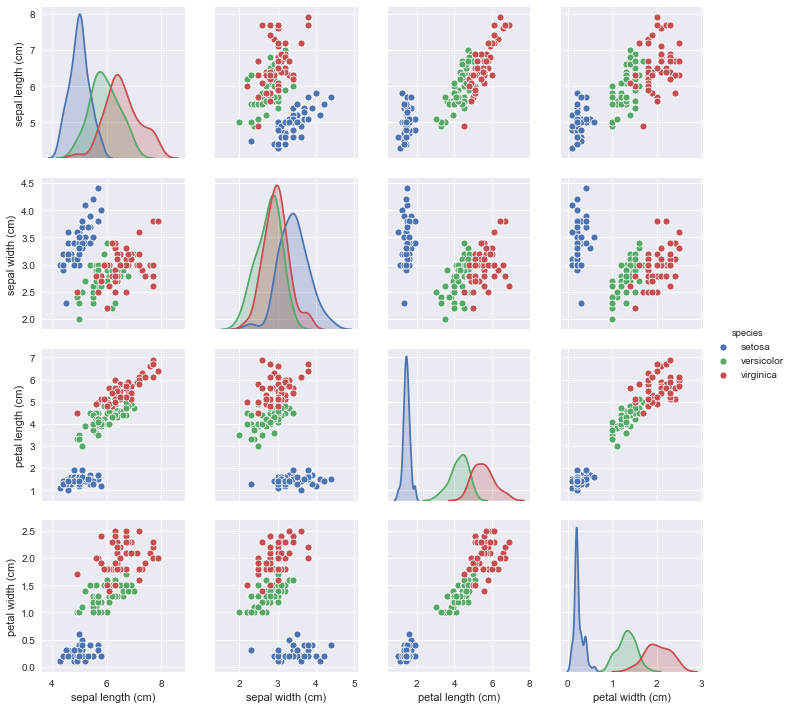

In [10]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# sklearn provides the iris species as integer values since this is required for classification
# here we're just adding a column with the species names to the dataframe for visualisation
df['species'] = np.array([iris.target_names[i] for i in iris.target])

sns.pairplot(df, hue='species')


In [11]:
# 본격적으로 분석을 시작 
# 데이터를 training 과 test 세트로 나누겠습니다. 보통 75/25의 비율로 나누기 때문에 일단은 그렇게 하도록 하겠습니다.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[iris.feature_names], iris.target, test_size=0.25, stratify=iris.target, random_state=123456)

In [12]:
train_data = train_df.drop(columns=['id'],axis=1)

In [13]:
train_data.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [14]:
test_data = test_df.drop(columns=['id'])

In [15]:
test_data.head()

,bone_length,rotting_flesh,hair_length,has_soul,color
0,0.471774,0.387937,0.706087,0.698537,black
1,0.427332,0.645024,0.565558,0.451462,white
2,0.549602,0.491931,0.660387,0.449809,black
3,0.638095,0.682867,0.471409,0.356924,white
4,0.361762,0.583997,0.377256,0.276364,black


In [16]:
train_data.type.value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

**We assign a 1 to Ghoul, 2 to Goblin and 3 to Ghost, since we need numbers for calculation in the algorithm. We cannot use string in the Machine Learning Algorithm so we need to encode them with numbers**

In [17]:
le = LabelEncoder()
train_data['type'] = le.fit_transform(train_data['type'])
print(train_data.type.value_counts())

1    129
2    125
0    117
Name: type, dtype: int64


In [18]:
train_data_x = train_data.drop(columns=['type'],axis=1)
train_data_y = train_data['type'].values

We also have to covert the categorical variable into dummy variable. While creating dummy we need to remove one column to escape the dummy variable trap.

In [19]:
train_data_x = pd.get_dummies(train_data_x,columns=['color'],drop_first=True).values

In [20]:
y_data = pd.get_dummies(test_data, columns=['color'], drop_first=True).values

In [21]:
rfclf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=123456)  # RandomForestClassifier
rfclf.fit(train_data_x,train_data_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

In [22]:
y_pred = rfclf.predict(y_data)
submission['type'] = y_pred

In [23]:
submission['type'] = submission.type.map({0:"Ghost", 1:"Ghoul", 2:"Goblin"})

In [24]:
submission.to_csv('../working/submission.csv', index=False)